# Forecasting Housing Prices - Kaggle Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from scipy import stats 
import statsmodels.api as sm 
import pylab 
from scipy.special import boxcox, inv_boxcox

In [2]:
train = pd.read_csv(r'C:\Users\17813\Desktop\Python Datasets\House Prices\train.csv')
test = pd.read_csv(r'C:\Users\17813\Desktop\Python Datasets\House Prices\test.csv')

pd.set_option('display.max_columns', None)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## EDA

### Observe response variable

The goal of this notebook is to perform analysis on the housing prices data from Kaggle and build a model that can predict the target varabiel SalePrice based on the provided variables. Models that I am interested in using for this dataset are regression and random forest.

Let's observe the target variable SalePrice.

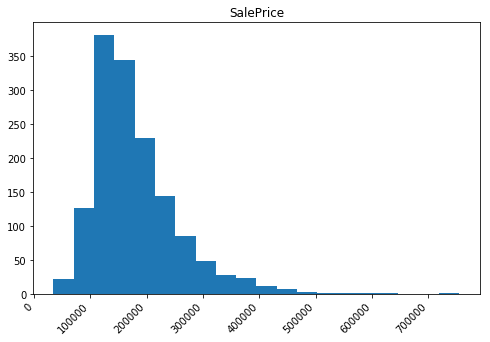

In [3]:
plt.figure(figsize=(8,5))

# plt.subplot(1, 2, 1)
plt.hist(train['SalePrice'], bins=20)
plt.gca().set_title('SalePrice')
plt.xticks(rotation=45, ha='right');

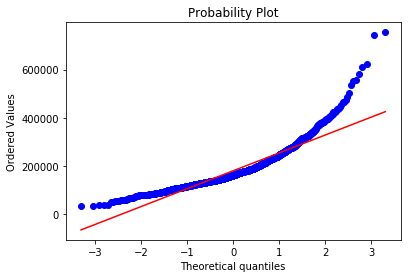

In [4]:
stats.probplot(train['SalePrice'], dist="norm", plot=pylab);

The distribution of SalePrice looks right skewed from the histogram and qqplot. There are more houses with lower sale prices compared to higher sale prices. To perform linear regression, there are several assumptions that the data should follow:
1. Linearity - The relationship between X and the mean of Y is linear.
2. Homoscedasticity - The variance of residual is the same for any value of X.
3. Independence - Observations are independent of each other.
4. Normality - For any fixed value of X, Y is normally distributed.

<br>
<br>
Source: https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html
<br>
<br>
Since SalePrice is not normally distributed, this means assumption #4 is not true. Applying a transformation such as box-cox transformation or logarithmic transformation can help to change the distribution and make it resemble a normal distribution.
<br>
<br>
I will apply both the box-cox transformation and a logarithmic transformation and see which one would be better to use.

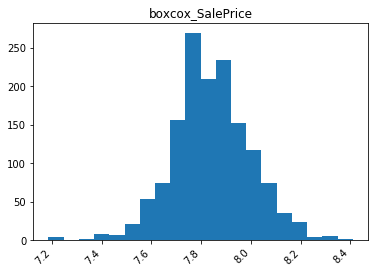

In [5]:
#apply boxcox transformation
train['boxcox_SalePrice'], lmbda =  stats.boxcox(train['SalePrice'])

plt.hist(train['boxcox_SalePrice'], bins=20)
plt.gca().set_title('boxcox_SalePrice')
plt.xticks(rotation=45, ha='right');

In [6]:
print(lmbda)

-0.07692396374428875


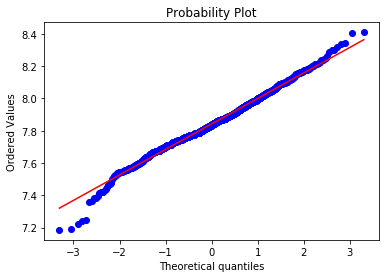

In [7]:
stats.probplot(train['boxcox_SalePrice'], dist="norm", plot=pylab);

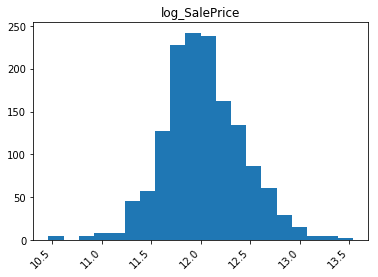

In [8]:
train['log_SalePrice'] =  np.log1p(train['SalePrice'])


#plot log transformation
plt.hist(np.log(train['SalePrice']), bins=20)
plt.gca().set_title('log_SalePrice')
plt.xticks(rotation=45, ha='right');

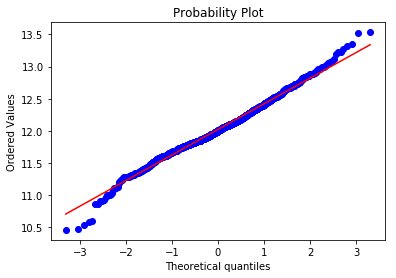

In [9]:
stats.probplot(np.log(train['SalePrice']), dist="norm", plot=pylab);

Both boxcox and log tranformation were able to transform the SalePrice response variable into a normal distribution and are very similar when looking at the qqplot. The boxcox transformation looks to be able to fit the upper tail values closer to the normal distribution compared to the log transformation, but the log transformation looks to be able to fit the lower tail values closer to the normal distribution.<br>
<br>
I will use the logarithmic transformation for the SalePrice response variable.

#### Observe predictors

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
Id                  1460 non-null int64
MSSubClass          1460 non-null int64
MSZoning            1460 non-null object
LotFrontage         1201 non-null float64
LotArea             1460 non-null int64
Street              1460 non-null object
Alley               91 non-null object
LotShape            1460 non-null object
LandContour         1460 non-null object
Utilities           1460 non-null object
LotConfig           1460 non-null object
LandSlope           1460 non-null object
Neighborhood        1460 non-null object
Condition1          1460 non-null object
Condition2          1460 non-null object
BldgType            1460 non-null object
HouseStyle          1460 non-null object
OverallQual         1460 non-null int64
OverallCond         1460 non-null int64
YearBuilt           1460 non-null int64
YearRemodAdd        1460 non-null int64
RoofStyle           1460 non-null object

In [11]:
train.shape

(1460, 83)

In [12]:
test.shape

(1459, 80)

#### Observe all of the missing values in the train and test dataset.

In [13]:
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total values missing', '%'])
missing_data[missing_data['Total values missing'] > 0]

,Total values missing,%
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageQual,81,5.5
GarageCond,81,5.5
GarageType,81,5.5
GarageYrBlt,81,5.5


In [14]:
total = test.isnull().sum().sort_values(ascending=False)
percent_1 = test.isnull().sum()/test.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total values missing', '%'])
missing_data[missing_data['Total values missing'] > 0].sort_values(by='Total values missing', ascending=False)

C:\Users\17813\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,Total values missing,%
PoolQC,1456,99.8
MiscFeature,1408,96.5
Alley,1352,92.7
Fence,1169,80.1
FireplaceQu,730,50.0
LotFrontage,227,15.6
GarageFinish,78,5.3
GarageQual,78,5.3
GarageYrBlt,78,5.3
GarageCond,78,5.3


After looking at the data description file provided, many of the columns with missing values mean that the house does not have that specific feature. For example, for the PoolQC column, NaN values mean the house has no pool. Columns that follow this are PoolQC, MiscFeature, Alley, Fence, FireplaceQu, and all of the Bsmt and Garage columns. 
<br>
<br>
The columns listed below have NaN values that don't have an actual purpose.


<b>LotFrontage</b> - This variable shows the linear feet of street connected to property. I am suspecting this variable is related to the Alley variable. Houses with No alley access may cause the LotFrontage to be a NaN value. I will have to look deeper into this and confirm this. This column has 259 missing values. I will keep this column for now.<br>
<b>MasVnrArea</b> - Masonry veneer area in square feet.<br>
<b>MasVnrType</b> - Masonry veneer type.<br>
<b>Electrical</b> - Electrical system.<br>
<br>
<br>
I will go ahead and fill in the missing values with the term 'None' rather than having NaN so I can see this category when I plot each categorical variable.

In [15]:
train[['PoolQC', 'MiscFeature', 
       'Alley', 'Fence', 
       'FireplaceQu', 'BsmtExposure', 
       'BsmtFinType2', 'BsmtFinType1', 
       'BsmtCond', 'BsmtQual',
       'GarageYrBlt',
       'GarageType','GarageFinish',
       'GarageQual','GarageCond']] = train[['PoolQC', 'MiscFeature', 
                                            'Alley', 'Fence', 
                                            'FireplaceQu', 'BsmtExposure', 
                                            'BsmtFinType2', 'BsmtFinType1', 
                                            'BsmtCond', 'BsmtQual',
                                            'GarageYrBlt',
                                            'GarageType','GarageFinish',
                                            'GarageQual','GarageCond']].fillna(value='None')

test[['PoolQC', 'MiscFeature', 
       'Alley', 'Fence', 
       'FireplaceQu', 'BsmtExposure', 
       'BsmtFinType2', 'BsmtFinType1', 
       'BsmtCond', 'BsmtQual','GarageYrBlt',
       'GarageType','GarageFinish',
       'GarageQual','GarageCond']] = test[['PoolQC', 'MiscFeature', 
                                           'Alley', 'Fence', 
                                           'FireplaceQu', 'BsmtExposure', 
                                           'BsmtFinType2', 'BsmtFinType1', 
                                           'BsmtCond', 'BsmtQual',
                                           'GarageYrBlt',
                                           'GarageType','GarageFinish',
                                           'GarageQual','GarageCond']].fillna(value='None')

I will now list the variables that are categorical and numeric.<br>
<br>
<b>Categorical</b> - MSSubClass, MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, MoSold, YrSold, SaleType, SaleCondition

<b>Numeric</b> - LotFrontage, LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, GarageArea, LowQualFinSF, GrLivArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal

I will start off by plotting the distribution of the numberic variables.

C:\Users\17813\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\17813\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


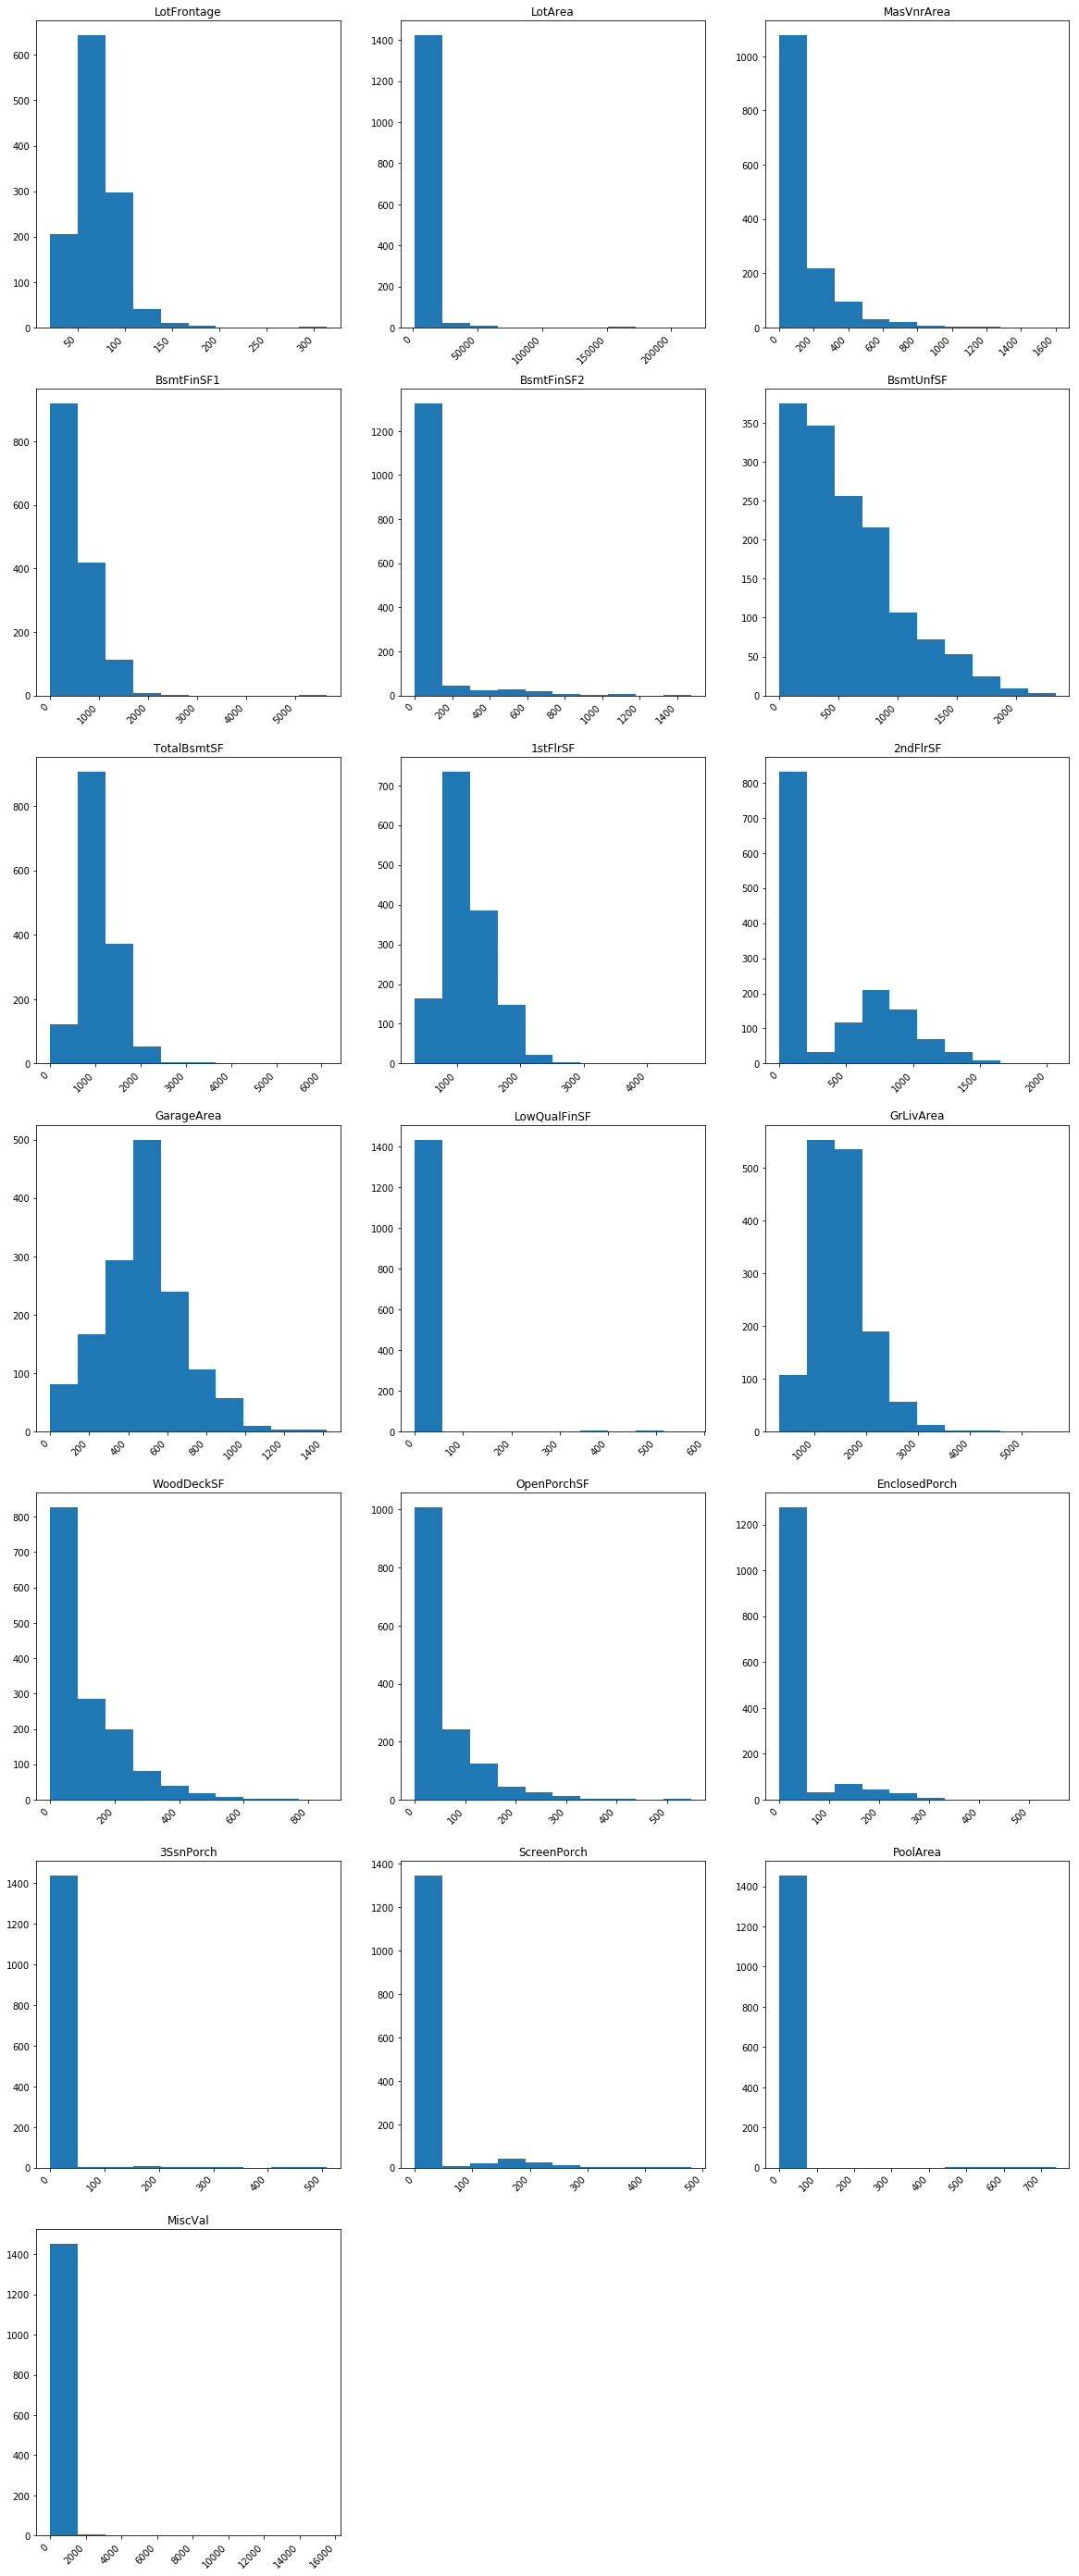

In [16]:
numeric_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
                'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GarageArea', 
                'LowQualFinSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

plt.figure(1, figsize=(20,50))

for i in enumerate(numeric_vars):
    plt.subplot(7, 3, i[0] + 1)
    plt.hist(train[i[1]])
    plt.gca().set_title(i[1])
    plt.xticks(rotation=45, ha='right')

In [17]:
train[numeric_vars].describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GarageArea,LowQualFinSF,GrLivArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1201.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,472.980137,5.844521,1515.463699,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041
std,24.284752,9981.264932,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,213.804841,48.623081,525.480383,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024
min,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,7553.500000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,334.500000,0.000000,1129.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,9478.500000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,480.000000,0.000000,1464.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80.000000,11601.500000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,576.000000,0.000000,1776.750000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,313.000000,215245.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,1418.000000,572.000000,5642.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


I will now plot the categorical variables.

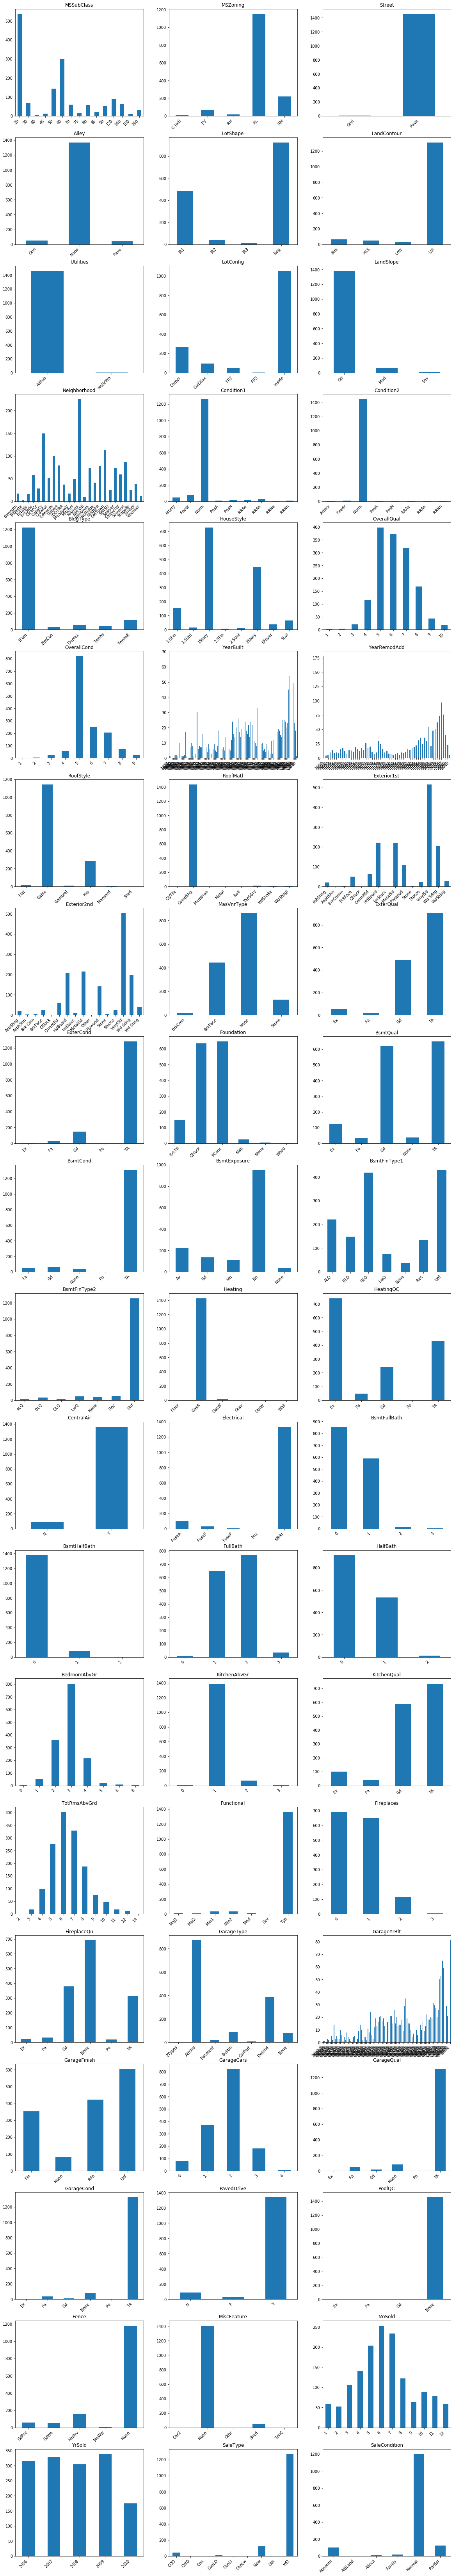

In [18]:
categorical_vars = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 
                    'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
                    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 
                    'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 
                    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
                    'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                    'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                    'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 
                    'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 
                    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                    'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

train[['PoolQC', 'MiscFeature', 
       'Alley', 'Fence', 
       'FireplaceQu', 'BsmtExposure', 
       'BsmtFinType2', 'BsmtFinType1', 
       'BsmtCond', 'BsmtQual',
       'GarageYrBlt',
       'GarageType','GarageFinish',
       'GarageQual','GarageCond']] = train[['PoolQC', 'MiscFeature',
                                            'Alley', 'Fence', 
                                            'FireplaceQu', 'BsmtExposure', 
                                            'BsmtFinType2', 'BsmtFinType1', 
                                            'BsmtCond', 'BsmtQual','GarageYrBlt',
                                            'GarageType','GarageFinish',
                                            'GarageQual','GarageCond']].astype('category')

plt.figure(1, figsize=(20,120))

for i in enumerate(categorical_vars):
    plt.subplot(20, 3, i[0] + 1)
    train[i[1]].value_counts().sort_index().plot(kind='bar')
    plt.gca().set_title(i[1])
    plt.xticks(rotation=45, ha='right')

Since the plots with years on the x axis are not visable, I will replot it below.

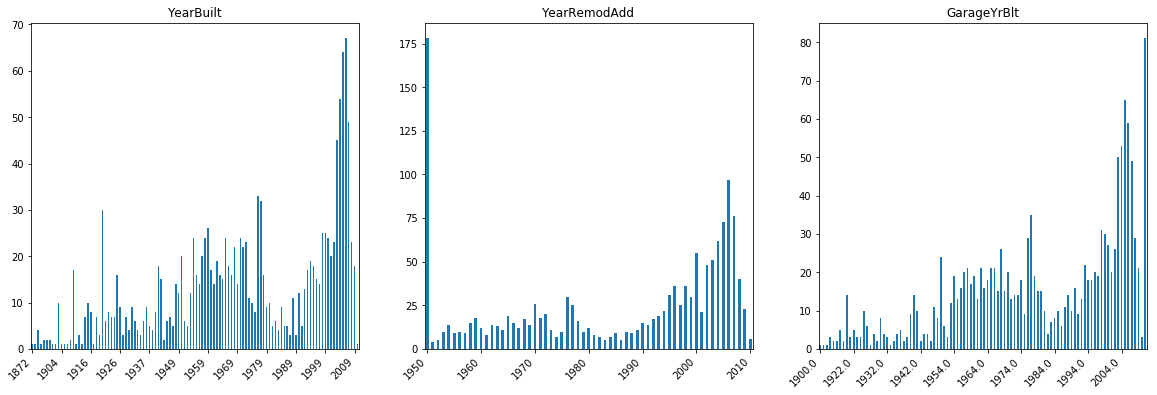

In [19]:
yrs = ['YearBuilt','YearRemodAdd','GarageYrBlt']

plt.figure(1, figsize=(20,6))

for i in enumerate(yrs):
    plt.subplot(1, 3, i[0] + 1)
    train[i[1]].value_counts().sort_index().plot(kind='bar')
    plt.gca().set_title(i[1])
    plt.xticks(rotation=45, ha='right')
    xticks = plt.gca().xaxis.get_major_ticks()
    for x in range(len(xticks)):
        if x % 10 != 0:
            xticks[x].set_visible(False)

Let's look at the distribution of the response variable SalePrice

I will now plot the SalePrice variable against all of the numerical variables using scatterplots to see how they are related to each other.

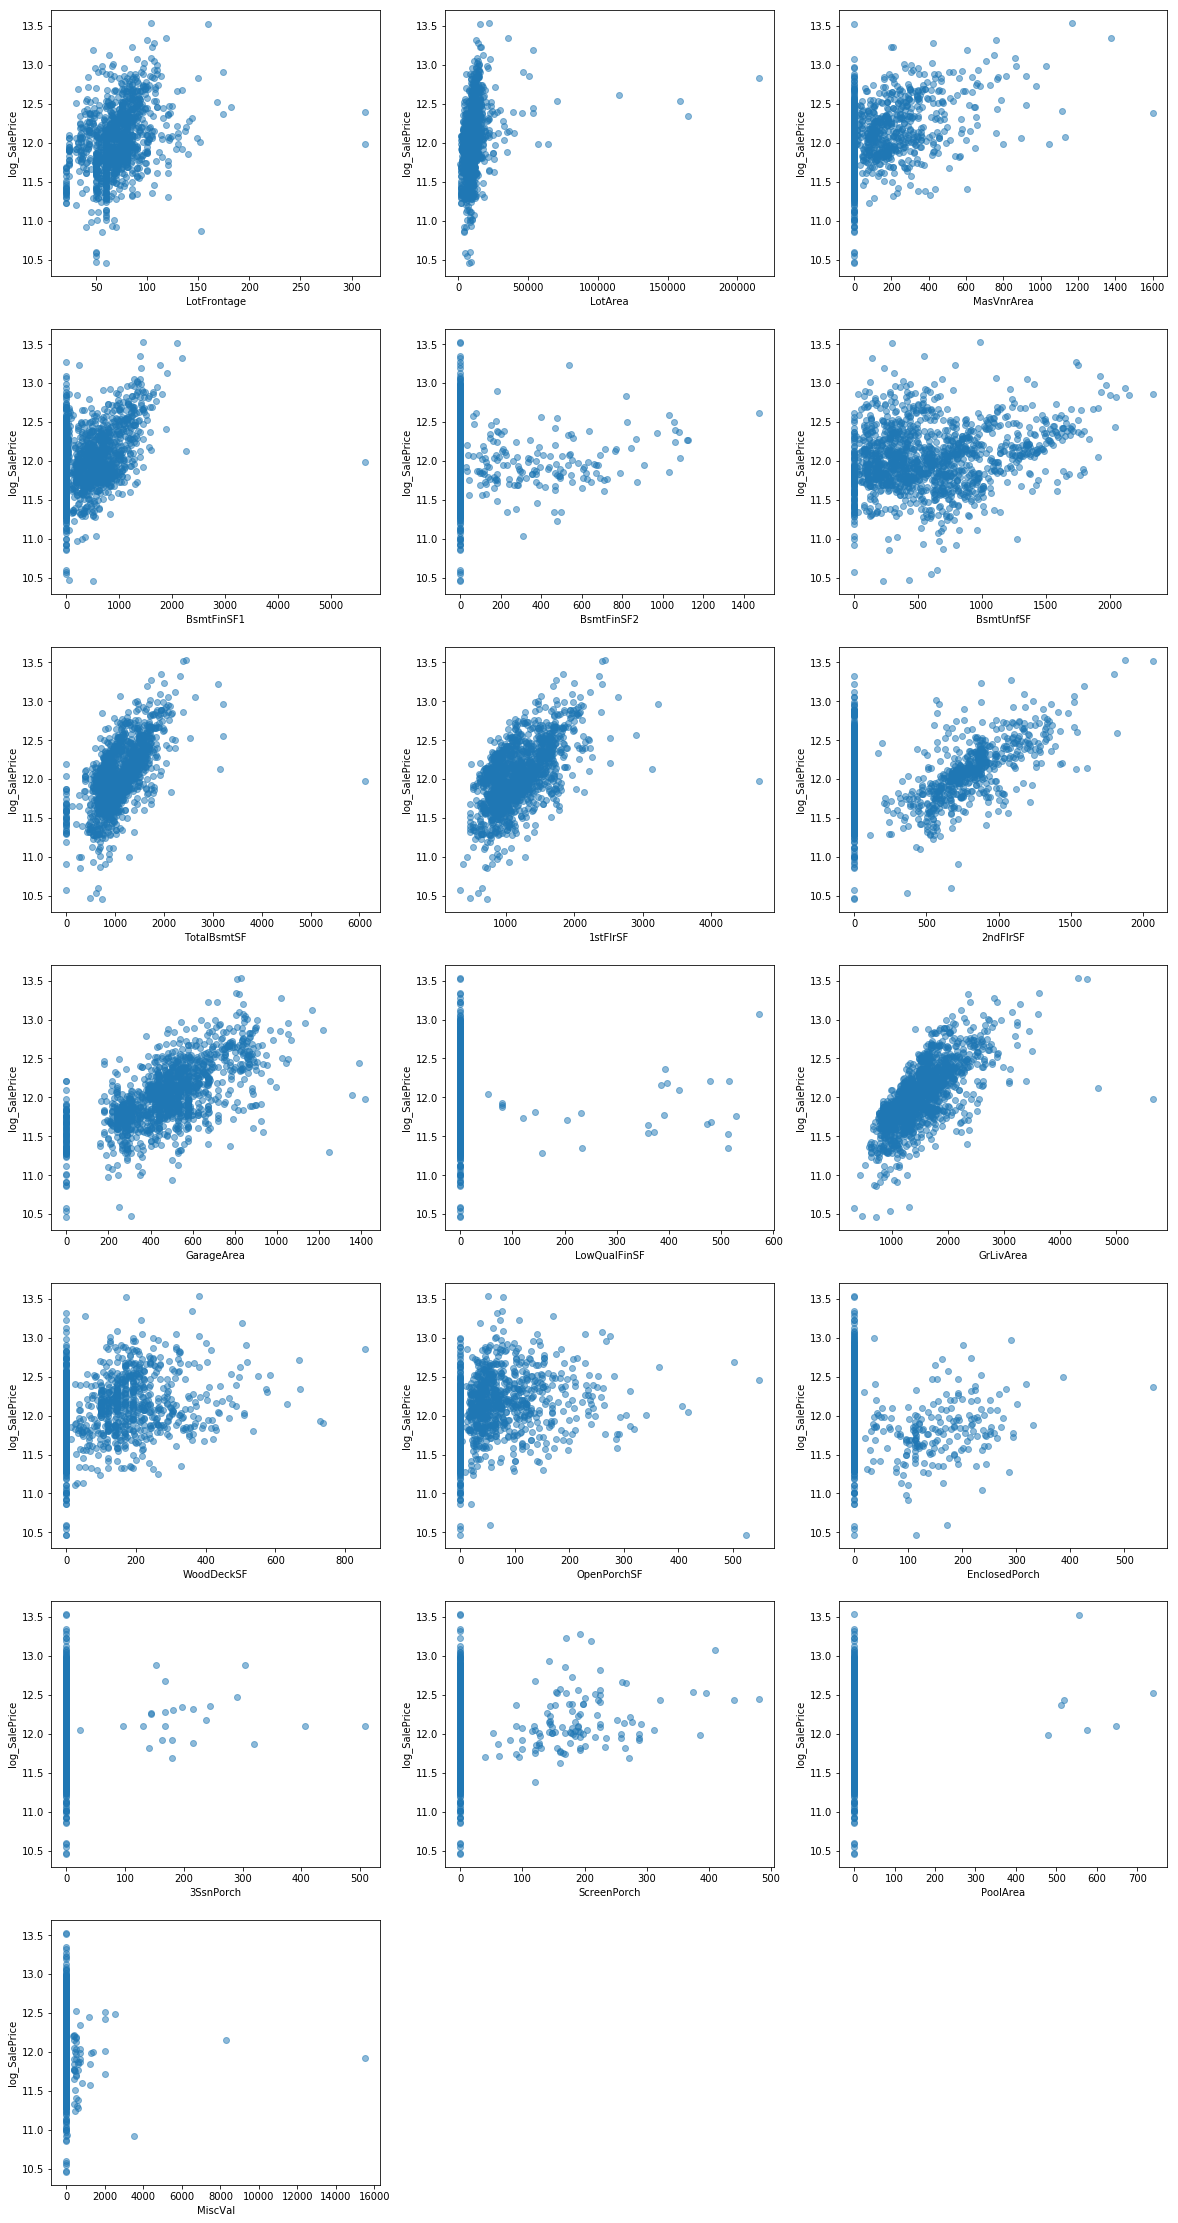

In [20]:
plt.figure(1, figsize=(20,40))

for i in enumerate(numeric_vars):
    plt.subplot(7, 3, i[0] + 1)
    plt.scatter(x=train[i[1]], y=train['log_SalePrice'], alpha=.5)
#     plt.gca().set_title(i[1])
    plt.xlabel(i[1])
    plt.ylabel('log_SalePrice')
#     plt.xticks(rotation=45, ha='right')

Looking at the scatterplots, the variables that seem to have the strongest correlation with SalePrice are GrLivArea, TotalBsmtSF, and 1stFlrSF. This is expected because GrLivArea and TotalBsmtSF combined are the total square feet of the entire house. 1stFlrSF will be related to the GrLivArea because the first floor is part of the above ground living area.
<br>
<br>
I will now plot each category among all of the categorical variables with SalePrice and see if there are any strong relations.

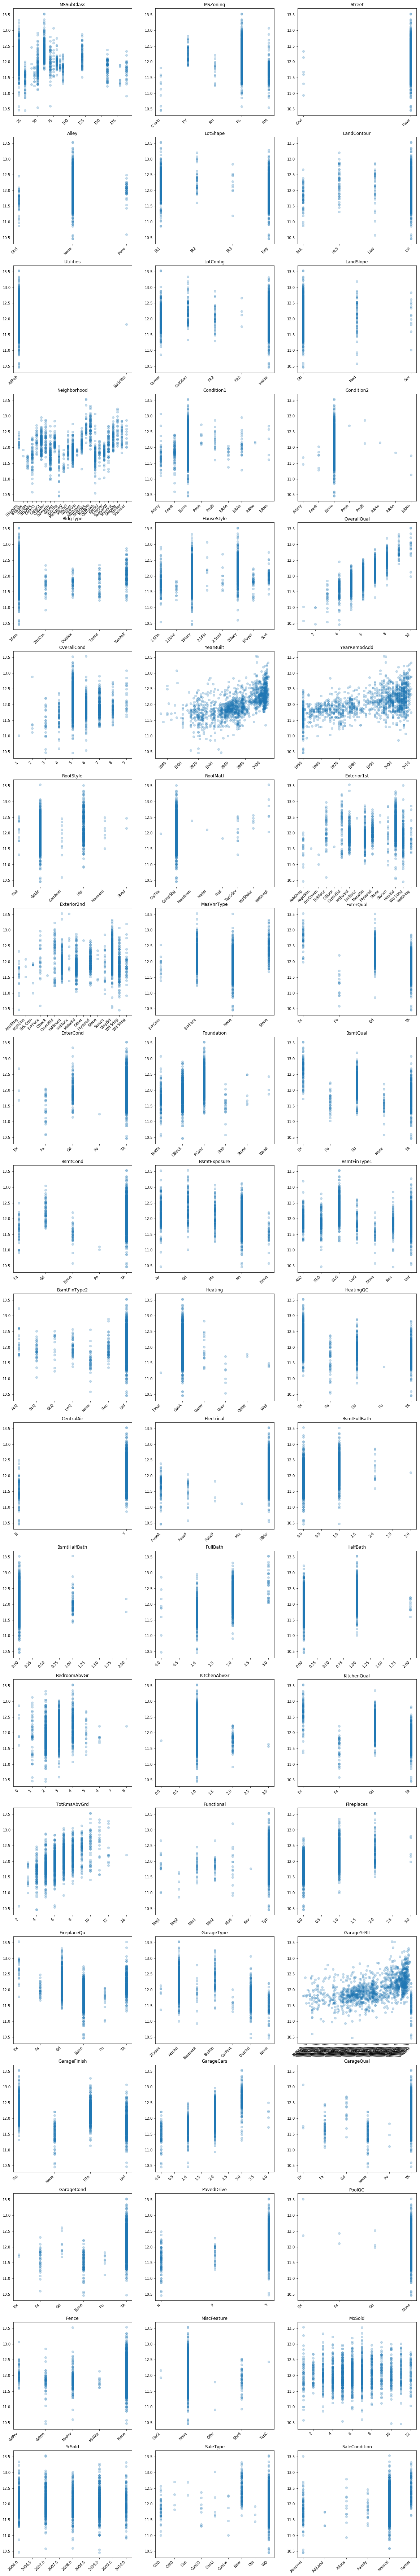

In [21]:
plt.figure(1, figsize=(20,130))

train['GarageYrBlt'] = train['GarageYrBlt'].astype('str')

temp = pd.DataFrame()

for i in enumerate(categorical_vars):
    plt.subplot(20, 3, i[0] + 1)
    temp = train[[i[1],'log_SalePrice']].dropna().reset_index(drop=1).sort_values(by=i[1])
    plt.scatter(x=temp.iloc[:,0], y=temp.iloc[:,1], alpha=.25)
#     plt.scatter(x=train[i[1]], y=train['SalePrice'])
#     train[i[1]].value_counts().sort_index().plot(kind='bar')
    plt.gca().set_title(i[1])
    plt.xticks(rotation=45, ha='right')

I will replot the GarageYrBlt against SalePrice because that is not as visable above. The 'None' GarageYrBlt values are on the right end of the x axis.

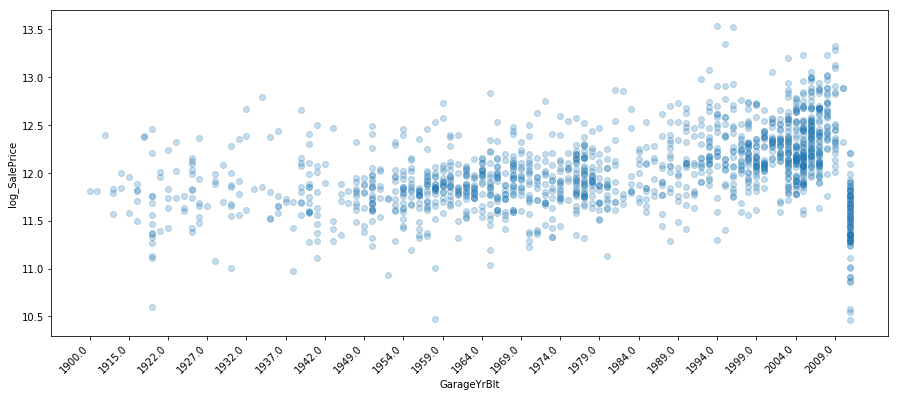

In [22]:
plt.figure(1, figsize=(15,6))
temp = train[['GarageYrBlt','log_SalePrice']].dropna().reset_index(drop=1).sort_values(by='GarageYrBlt')
plt.scatter(x=temp['GarageYrBlt'], y=temp['log_SalePrice'], alpha=.25)
plt.ylabel('log_SalePrice')
plt.xlabel('GarageYrBlt')
plt.xticks(rotation=45, ha='right');
xticks = plt.gca().xaxis.get_major_ticks()
for x in range(len(xticks)):
    if x % 5 != 0:
        xticks[x].set_visible(False)

Many of the categorical variables have categories that may indicate higher SalePrices, but aren't very strong indicators when only looking at each one individually because of wide spread of SalePrice among each category.<br>
<br>
Some variables that may be a strong indicator are: Neighborhood, OverallQual, TotRmsAbvGrd. There may be more, but these seem to be the clearest from the plots above
<br>
<br>
There are some categorical variables don't show any indication of SalePrice such as Utilities and Street. These can be removed from the dataset.

Let's take a look at a heatmap to show which of the numerical variables have a high correlation to each other.

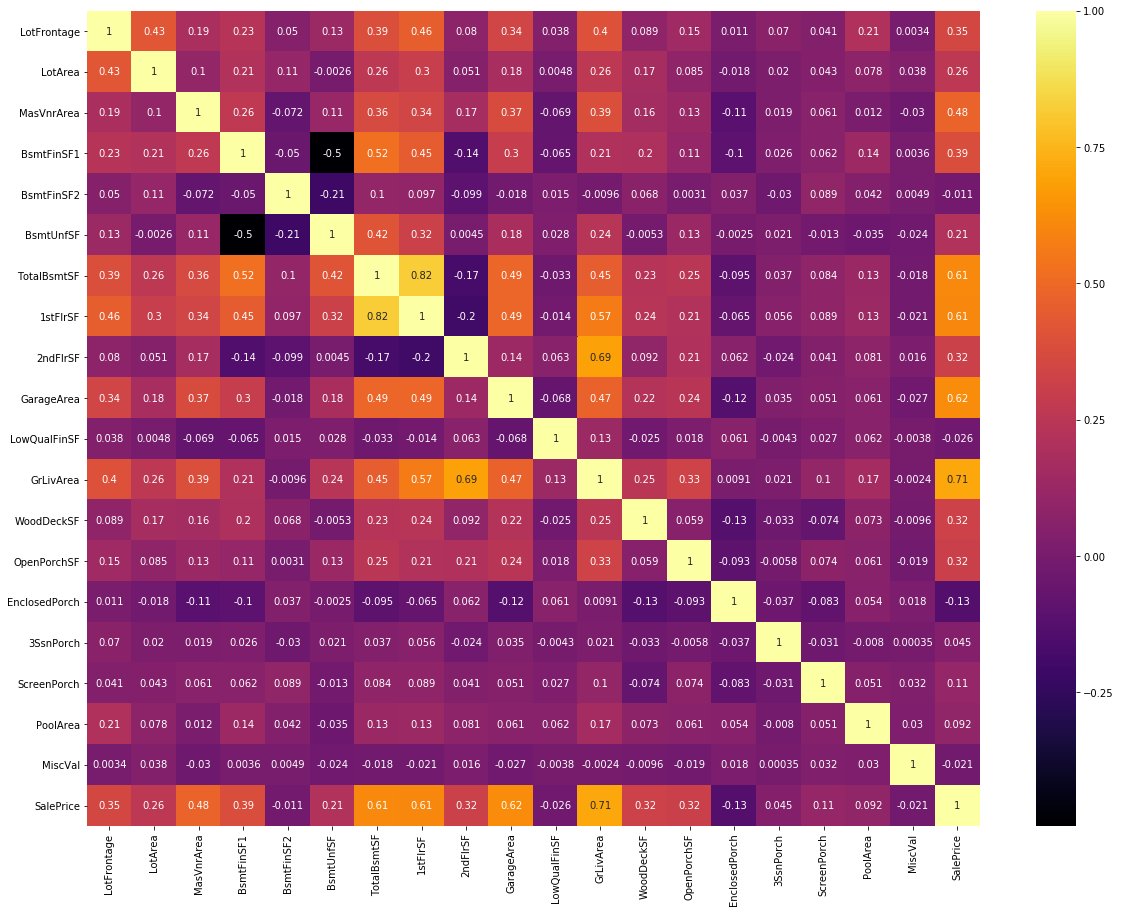

In [23]:
numeric_vars2 = numeric_vars + ['SalePrice']

plt.figure(figsize=(20,15))

sns.heatmap(train[numeric_vars2].corr(), cmap='inferno', annot=True);

A number of variables are correlated with eachother which will cause multicollinearity and affect the model's predictions. I will inspect this further by looking at the variance inflation factor of each of the numerical variables. This requires filling in the missing values first.

## Data Preprocessing

#### Missing values

As mentioned earlier, a lot of the columns with NaN values have a specific purpose for it. Those columns were already dealt with by replacing the NaN values with the category called 'None'. For the other columns that have NaN values, I will use imputation to deal with the missing values.
<br>
<br>
Let's take a look at the remaining columns that have missing values.

In [24]:
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total values missing', '%'])
missing_data[missing_data['Total values missing'] > 0]

,Total values missing,%
LotFrontage,259,17.7
MasVnrType,8,0.5
MasVnrArea,8,0.5
Electrical,1,0.1


In [25]:
total = test.isnull().sum().sort_values(ascending=False)
percent_1 = test.isnull().sum()/test.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total values missing', '%'])
missing_data[missing_data['Total values missing'] > 0].sort_values(by='Total values missing', ascending=False)

C:\Users\17813\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,Total values missing,%
LotFrontage,227,15.6
MasVnrType,16,1.1
MasVnrArea,15,1.0
MSZoning,4,0.3
Utilities,2,0.1
BsmtFullBath,2,0.1
BsmtHalfBath,2,0.1
Functional,2,0.1
TotalBsmtSF,1,0.1
SaleType,1,0.1


I will impute the numerical variables with either the mean of the variable or with 0 depending on the frequency of the values. I will impute all categorical variables with the most common category within the variable.

In [26]:
#impute LotFrontage
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer = imputer.fit(train[['LotFrontage']])
train['LotFrontage'] = imputer.transform(train[['LotFrontage']])

imputer = imputer.fit(test[['LotFrontage']])
test['LotFrontage'] = imputer.transform(test[['LotFrontage']])

test[['BsmtFullBath','BsmtHalfBath',
      'GarageCars','GarageArea',
      'BsmtFinSF2','BsmtFinSF1',
      'BsmtUnfSF','TotalBsmtSF',
      'MasVnrArea']] = test[['BsmtFullBath','BsmtHalfBath',
                             'GarageCars','GarageArea',
                             'BsmtFinSF2','BsmtFinSF1',
                             'BsmtUnfSF','TotalBsmtSF',
                             'MasVnrArea']].fillna(0)

train[['MasVnrArea']] = train[['MasVnrArea']].fillna(0)

In [27]:
#impute MasVnrType
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='None')
imputer = imputer.fit(train[['MasVnrType']])
train['MasVnrType'] = imputer.transform(train[['MasVnrType']])
imputer = imputer.fit(test[['MasVnrType']])
test['MasVnrType'] = imputer.transform(test[['MasVnrType']])

#impute Electrical
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='SBrkr')
imputer = imputer.fit(train[['Electrical']])
train['Electrical'] = imputer.transform(train[['Electrical']])

#impute MSZoning
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='RL')
imputer = imputer.fit(train[['MSZoning']])
test['MSZoning'] = imputer.transform(test[['MSZoning']])

#impute Functional
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Typ')
imputer = imputer.fit(train[['Functional']])
test['Functional'] = imputer.transform(test[['Functional']])

#impute Utilities
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='AllPub')
imputer = imputer.fit(train[['Utilities']])
test['Utilities'] = imputer.transform(test[['Utilities']])

#impute Exterior2nd
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='VinylSd')
imputer = imputer.fit(train[['Exterior2nd']])
test['Exterior2nd'] = imputer.transform(test[['Exterior2nd']])

#impute SaleType
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='WD')
imputer = imputer.fit(train[['SaleType']])
test['SaleType'] = imputer.transform(test[['SaleType']])

#impute Exterior1st
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='VinylSd')
imputer = imputer.fit(train[['Exterior1st']])
test['Exterior1st'] = imputer.transform(test[['Exterior1st']])

#impute KitchenQual
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='TA')
imputer = imputer.fit(train[['KitchenQual']])
test['KitchenQual'] = imputer.transform(test[['KitchenQual']])

#### Calculate VIF of numerical variables

In [28]:
#calculate vif for numerical columns
X = add_constant(train[numeric_vars])
pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], 
          index=X.columns)

C:\Users\17813\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\17813\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const            17.859466
LotFrontage       1.348378
LotArea           1.196409
MasVnrArea        1.329777
BsmtFinSF1             inf
BsmtFinSF2             inf
BsmtUnfSF              inf
TotalBsmtSF            inf
1stFlrSF               inf
2ndFlrSF               inf
GarageArea        1.583751
LowQualFinSF           inf
GrLivArea              inf
WoodDeckSF        1.168161
OpenPorchSF       1.170497
EnclosedPorch     1.073963
3SsnPorch         1.012741
ScreenPorch       1.052736
PoolArea          1.076319
MiscVal           1.006435
dtype: float64

Looking at the list of VIFs, some variables have a VIF of infinity. This means that those variables have perfect correlation. The variables that have this are area spaces in the house such as area of the 1st floor, 2nd floor, basement, garage, etc. The area of the 1st and 2nd floor should be very similar in most houses unless the house doesn't have a second floor.
<br>
<br>
Variables with large VIF will affect the results of a regression model so this will have to be removed if I want to use a regression model. A possible way to deal with this is by combining feature that have a high correlation by performing feature engineering to create new features by combining existing ones.

## Feature Engineering

I will start off by combining the total SF area of the house (garage, basement, 1st floor, 2nd floor) into a variable called TotalSF. Features such as the SF of ScreenPorch, 3SsnPorch, EnclosedPorch, OpenPorchSF, and PoolArea don't have a strong correlation with the SalePrice, so I will include these variables in TotalSF to reduce the total number of features.

In [29]:
train[numeric_vars].head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GarageArea,LowQualFinSF,GrLivArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,65.0,8450,196.0,706,0,150,856,856,854,548,0,1710,0,61,0,0,0,0,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,460,0,1262,298,0,0,0,0,0,0
2,68.0,11250,162.0,486,0,434,920,920,866,608,0,1786,0,42,0,0,0,0,0
3,60.0,9550,0.0,216,0,540,756,961,756,642,0,1717,0,35,272,0,0,0,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,836,0,2198,192,84,0,0,0,0,0


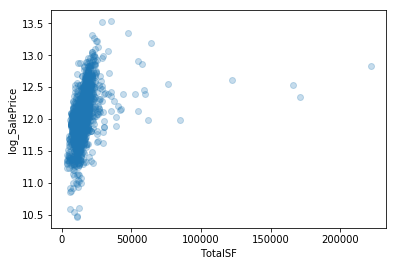

In [30]:
#create TotalSF variable in train dataset
train['TotalSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['GarageArea'] + train['LowQualFinSF'] + \
                   train['TotalBsmtSF'] + train['GrLivArea'] + train['EnclosedPorch'] + train['3SsnPorch'] + \
                   train['ScreenPorch'] + train['PoolArea'] + train['OpenPorchSF'] + train['WoodDeckSF'] + \
                   train['LotArea'] + train['LotFrontage'] + train['MasVnrArea'] 

plt.scatter(x=train['TotalSF'], y=train['log_SalePrice'], alpha=.25)
plt.xlabel('TotalSF')
plt.ylabel('log_SalePrice');

#create TotalSF variable in test dataset
test['TotalSF'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['GarageArea'] + test['LowQualFinSF'] + \
                  test['TotalBsmtSF'] + test['GrLivArea'] + test['EnclosedPorch'] + test['3SsnPorch'] + \
                  test['ScreenPorch'] + test['PoolArea'] + test['OpenPorchSF'] + test['WoodDeckSF'] + \
                  test['LotArea'] + test['LotFrontage'] + test['MasVnrArea'] 

The new TotalSF variable has a correlation to the SalePrice which will be useful in predicting the SalePrice. I can now drop the columns used to create this variable because they are now redundant.
<br>
<br>
TotalBsmtSF was the combined total of BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, so I can drop these columns as well.

I will create a new feature called SaleAge which is YrSold - YearBuilt. I will also create a binary variable called HasRemodeled which will be 0 if the YearRemodAdd equals YearBuilt and 1 if YearRemodAdd does not equal YearBuilt. I will do the same for GarageYrBlt which will be 1 if the house has a value for GarageYrBlt and 0 for None values, this variable will be called HasGarage.

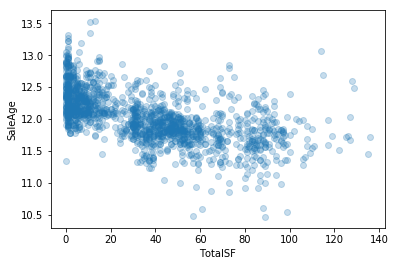

In [31]:
plt.scatter(x=(train['YrSold'] - train['YearBuilt']), y=train['log_SalePrice'], alpha=.25)
plt.xlabel('TotalSF')
plt.ylabel('SaleAge');

In [32]:
#create new columns for training set
train['SaleAge'] = train['YrSold'] - train['YearBuilt']


train['HasRemodeled'] = train['YearRemodAdd'] - train['YearBuilt']

train['HasRemodeled'][train['HasRemodeled'] != 0] = 1

train['HasGarage'] = train['GarageYrBlt']
train['HasGarage'][train['HasGarage'] != 'None'] = 1
train['HasGarage'][train['HasGarage'] == 'None'] = 0

#create the same for test set
test['SaleAge'] = test['YrSold'] - test['YearBuilt']


test['HasRemodeled'] = test['YearRemodAdd'] - test['YearBuilt']

test['HasRemodeled'][test['HasRemodeled'] != 0] = 1

test['HasGarage'] = test['GarageYrBlt']
test['HasGarage'][test['HasGarage'] != 'None'] = 1
test['HasGarage'][test['HasGarage'] == 'None'] = 0

C:\Users\17813\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\17813\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\17813\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\17813\Anaconda3\li

I can drop the YearBuilt, YearRemodAdd, GarageYrBlt, and YrSold columns now due to the new variables.
<br>
<br>
I will also drop the MiscVal column, this column doesn't provide much information about the sale price of a home.

## Drop features

In [33]:
drop_numerical = ['1stFlrSF', '2ndFlrSF', 'GarageArea', 'LowQualFinSF', 
            'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','GrLivArea', 
            'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'OpenPorchSF', 
            'WoodDeckSF', 'LotArea', 'LotFrontage', 'MasVnrArea', 'MiscVal']

#drop from training set
train.drop(train[drop_numerical], axis=1, inplace=True)

#drop from test set
test.drop(test[drop_numerical], axis=1, inplace=True)

In [34]:
#update numeric_vars list
numeric_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'MiscVal']

In [35]:
train[categorical_vars].head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,TA,TA,Y,None,None,None,2,2008,WD,Normal
1,20,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,TA,TA,Y,None,None,None,5,2007,WD,Normal
2,60,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,TA,TA,Y,None,None,None,9,2008,WD,Normal
3,70,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,TA,TA,Y,None,None,None,2,2006,WD,Abnorml
4,60,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,TA,TA,Y,None,None,None,12,2008,WD,Normal


I will now drop categorical variables that have a large majority under 1 category. For example, if 95%+ of a categorical variable is within the 'None' category, I will remove the column to make the model more simple rather than including the column.

I will drop the categorical columns MiscFeature, PoolQC, Functional, KitchenAbvGr, BsmtHalfBath, Heating, RoofMatl, Condition2, LandSlope, Alley. All of these columns have atleast 93% within a single category of the column.

In [36]:
drop_categories = ['MiscFeature', 'PoolQC', 'Functional', 'KitchenAbvGr', 'BsmtHalfBath', 
                   'Heating', 'RoofMatl', 'Condition2', 'LandSlope', 'Alley', 'YearBuilt', 
                   'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'Street']

In [37]:
#drop for train set
train.drop(train[drop_categories], axis=1, inplace=True)

#drop for test set
test.drop(test[drop_categories], axis=1, inplace=True)

## Encode categorical variables

In [38]:
#convert category columns to objects
train[train.select_dtypes(include = [object]).columns] = train[train.select_dtypes(include = [object]).columns].astype('category')
test[test.select_dtypes(include = [object]).columns] = test[test.select_dtypes(include = [object]).columns].astype('category')

#convert categoric variables to objects
train[['MSSubClass', 'OverallQual', 'OverallCond',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'MoSold', 'SaleAge',
       'HasRemodeled']] = train[['MSSubClass', 'OverallQual', 'OverallCond',
                                 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
                                 'Fireplaces', 'GarageCars', 'MoSold', 'SaleAge',
                                 'HasRemodeled']].astype('category')

test[['MSSubClass', 'OverallQual', 'OverallCond',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'MoSold', 'SaleAge',
       'HasRemodeled']] = test[['MSSubClass', 'OverallQual', 'OverallCond',
                                 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
                                 'Fireplaces', 'GarageCars', 'MoSold', 'SaleAge',
                                 'HasRemodeled']].astype('category')

train[['HasRemodeled', 'HasGarage']] = train[['HasRemodeled', 'HasGarage']].astype('int')
test[['HasRemodeled', 'HasGarage']] = test[['HasRemodeled', 'HasGarage']].astype('int')

In [39]:
#encode columns
train['CentralAir'] = train['CentralAir'].cat.codes

test['CentralAir'] = test['CentralAir'].cat.codes

In [40]:
#one hot encode columns
dummy_cols = ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood',
             'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
             'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
             'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish',
             'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MoSold', 'SaleType', 'SaleCondition', 'OverallQual',
             'OverallCond', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
             'GarageCars', 'SaleAge']

combined = pd.concat([(train.drop(['SalePrice','boxcox_SalePrice'], axis=1)), test], axis=0)

combined_encoded = pd.get_dummies(combined, columns=dummy_cols)
combined_encoded.head()

C:\Users\17813\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,CentralAir,HasGarage,HasRemodeled,Id,TotalSF,log_SalePrice,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondit

In [41]:
#split back into individual train and test sets
train_encoded = combined_encoded[:train.shape[0]]
test_encoded = combined_encoded[train.shape[0]:]

## Split the dataset

In [42]:
X_train = train_encoded.drop(['Id', 'log_SalePrice'], axis=1)
y_train = train_encoded['log_SalePrice']

## Create evaluation function

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5

def rmsle_CV(model):
    kf = KFold(n_folds,shuffle=True,random_state=1).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)

## Build models

In [44]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.datasets import make_regression

import xgboost as xgb

C:\Users\17813\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\17813\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


#### Random Forest Regressor

In [46]:
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=0, shuffle=False)

RF_reg = RandomForestRegressor(max_depth=2, random_state=0)
score = rmsle_CV(RF_reg)
print("Random Forest Regressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\Users\17813\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\17813\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\17813\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\17813\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regressor score: 0.2479 (0.0160)



C:\Users\17813\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Lasso Regression

In [47]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_CV(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1421 (0.0095)



#### Ridge Regression

In [48]:
ridge = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_CV(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\Users\17813\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=5.94147e-19): result may not be accurate.
  overwrite_a=False)
C:\Users\17813\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=1.07763e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\17813\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=8.72644e-19): result may not be accurate.
  overwrite_a=False)
C:\Users\17813\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=6.55245e-19): result may not be accurate.
  overwrite_a=False)


Kernel Ridge score: 0.3468 (0.2653)



C:\Users\17813\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=8.90028e-19): result may not be accurate.
  overwrite_a=False)


#### Elastic Net Regression

In [49]:
Elastic_Net = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_CV(Elastic_Net)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1420 (0.0094)



#### Model selection

I will use the elastic net model because it has the lowest RMSLE value compared to all of the other models tested.

In [50]:
ENet_model = Elastic_Net.fit(X_train.values,y_train)

final_preds = np.expm1(ENet_model.predict(test_encoded.drop(['Id', 'log_SalePrice'], axis=1)))

In [52]:
submission_df = pd.DataFrame(test_encoded['Id'])
submission_df['SalePrice'] = final_preds


submission_df.to_csv('C:/Users/17813/Desktop/Python Datasets/House Prices/submission.csv',index=False)

My submission yielded a RMSLE of 0.15238 on the test dataset. There are still many ways I can improve my score such as trying out new models, changing my approach to feature selection, and coming up with other features in feature engineering.